# Comparison of scenarios

In [2]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import os

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
when = 'future'
file_prefix = f'week'
outdir = '2021-01-19-107_90/'

n_int_steps = 6
nnodes = 107  # nodes
ndays_ocp = 90
ndays = 90

setup = ItalySetup(nnodes, ndays, when)
setup_ocp = ItalySetup(nnodes, ndays_ocp, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)
    
os.makedirs('model_output/scenarios', exist_ok=True)

scenarios = {pick_scenario(setup, i)['name']:pick_scenario(setup, i) for i in np.arange(12)}
scenarios.keys()

Loaded Italy Setup with 107 nodes.
Loaded Italy Setup with 107 nodes.


dict_keys(['U-r3-t479700-id0', 'L-r3-t479700-id1', 'U-r15-t125000-id2', 'L-r15-t125000-id3', 'U-r15-t250000-id4', 'L-r15-t250000-id5', 'U-r15-t479700-id6', 'L-r15-t479700-id7', 'U-r15-t1000000-id8', 'L-r15-t1000000-id9', 'U-r150-t479700-id10', 'L-r150-t479700-id11'])

In [11]:
summary = pd.read_csv('model_output/scenarios_102_90/all_summary.csv', index_col=0)
#summary.replace('opi', 'Optimal', inplace=True)
#summary.replace('inc', 'Incidence', inplace=True)
#summary.replace('cas', 'Future Incidence', inplace=True)
#summary.replace('pop', 'Population', inplace=True)
#summary.replace('sus', 'Susceptibility', inplace=True)
summary.replace('U', 'Pessimistic', inplace=True)
summary.replace('L', 'Optimistic', inplace=True)

In [4]:
summary

,newdoseperweek,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,bl,averted,avertedpervacc
0,479700,Optimal,3.006920e+08,0.0,6.318088e+06,Pessimistic,r3,t479700,U-r3-t479700-id0,3.091563e+08,8.464291e+06,1.339692
1,479700,Optimal,2.924840e+08,1.0,6.318088e+06,Pessimistic,r3,t479700,U-r3-t479700-id0,3.003535e+08,7.869518e+06,1.245554
2,479700,Optimal,2.792843e+08,2.0,6.318088e+06,Pessimistic,r3,t479700,U-r3-t479700-id0,2.866484e+08,7.364111e+06,1.165560
3,479700,Optimal,2.840928e+08,3.0,6.318088e+06,Pessimistic,r3,t479700,U-r3-t479700-id0,2.916792e+08,7.586442e+06,1.200750
4,479700,Optimal,2.704770e+08,4.0,6.318088e+06,Pessimistic,r3,t479700,U-r3-t479700-id0,2.778097e+08,7.332666e+06,1.160583
...,...,...,...,...,...,...,...,...,...,...,...,...
97,479700,fpop,9.864285e+07,97.0,6.236100e+06,Optimistic,r150,t479700,L-r150-t479700-id11,1.005111e+08,1.868235e+06,0.299584
98,479700,fpop,1.036543e+08,98.0,6.236100e+06,Optimistic,r150,t479700,L-r150-t479700-id11,1.062793e+08,2.624949e+06,0.420928
99,479700,fpop,1.058738e+08,99.0,6.236100e+06,Optimistic,r150,t479700,L-r150-t479700-id11,1.078101e+08,1.936351e+06,0.310507
100,479700,fpop,9.955109e+07,100.0,6.236100e+06,Optimistic,r150,t479700,L-r150-t479700-id11,1.016478e+08,2.096725e+06,0.336224


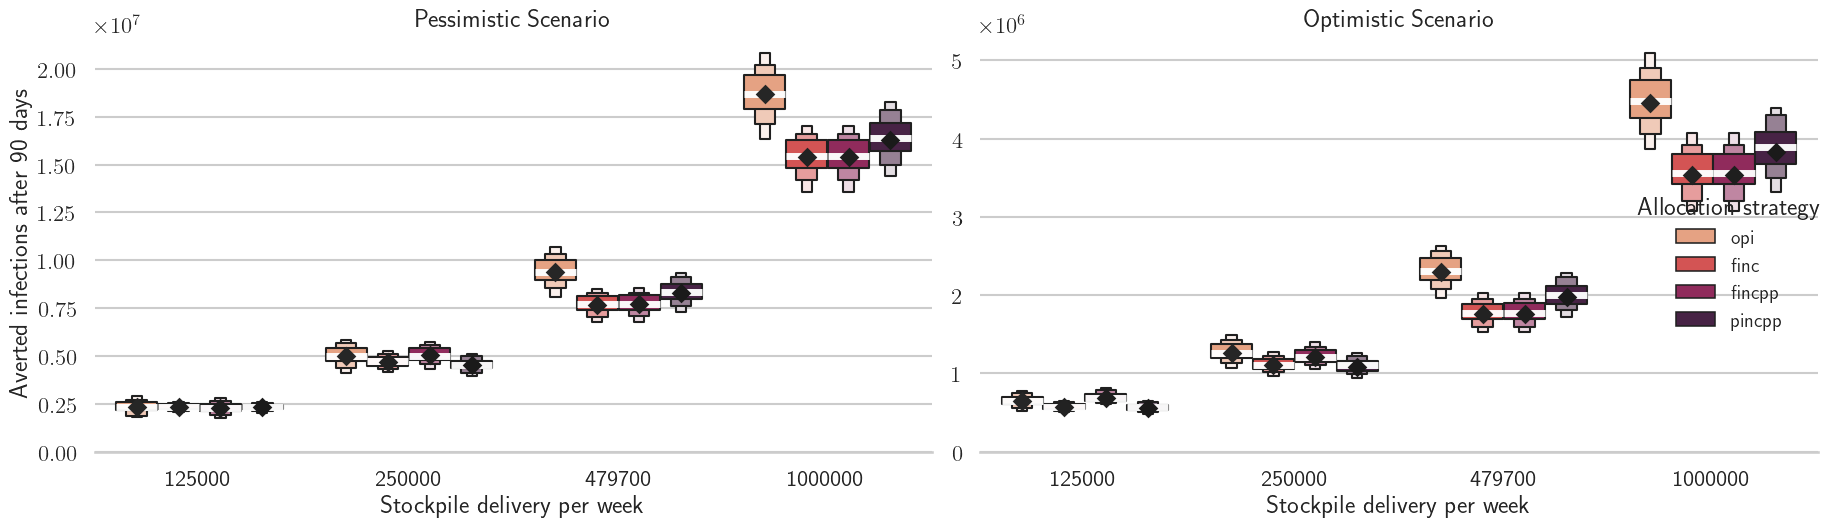

In [44]:
methods = ['opi', 'finc', 'pinc', 'fsus', 'psus','fincpp', 'pincpp', 'fsuspp', 'psuspp', 'ppop', 'fpop']
methods = ['opi', 'finc','fincpp', 'pincpp']
#methods = ['opi', 'pinc','ppop', 'psus']

toplot = "averted"
#var_x = "scenario-rate"  
var_x = "newdoseperweek" 

#smry = summary[(summary['scenario-tot']=='t479700') & (summary['method'].isin(methods))]

smry = summary[(summary['scenario-rate']=='r15') & (summary['method'].isin(methods))]

mpl.rc('text', usetex=True)
mpl.rc('font', size=14)
mpl.rc('legend', fontsize=14)

grid = sns.FacetGrid(smry, col="scenario-beta",  palette="mako", height=5.5, aspect = 1.5, col_wrap=2, sharey=False,sharex=True)
def quantile_plot(index, reduction, method, scn_beta, **kwargs):

    g = sns.boxenplot(
            #data=smry,,
            x=index, y=reduction,
            hue=method,
            palette="rocket_r",
            dodge=9,
            #size=2,
            #alpha = .4,
            #inner="stick"
            showfliers=False,
        
        )
    ax = plt.gca()
    ax.set_ylim(0)
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    plt.legend()
    
    for line in ax.get_lines():
        line.set_color('white')
        line.set_linewidth(5)
        line.set_alpha(10)
    



# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, var_x, toplot, "method", "scenario-beta")#, marker="o")

grid.add_legend(title='Allocation strategy')


def quantile_plot(index, reduction, method, scn_beta, **kwargs):
    g2 = sns.stripplot(
        x=var_x,
        y=toplot,
        data = smry[(smry['post_sample']==101) & (smry['scenario-beta']==scn_beta.unique()[0])], 
        dodge=.63, 
        hue="method",
        jitter=False,
        #ax = ax,
       color = 'k',
        #palette="husl",
        marker="D",   # passed to https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter
        s=10, 
        linewidths = 10,
        edgecolors = 'k',
        zorder=100000,
    )
grid.map(quantile_plot, "newdoseperweek", toplot, "method", "scenario-beta")#, marker="o")


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        
# Adjust the arrangement of the plots
#grid.fig.suptitle(run_name)
grid.despine(left=True)

grid.set_axis_labels("Stockpile delivery per week","Averted infections after 90 days",)
grid.set_titles(col_template="{col_name} Scenario", row_template="{row_name}")
grid.fig.tight_layout(w_pad=1)
grid.fig.savefig(f'figures/scenarios_perturb_all.pdf')

In [46]:
filename = 'model_output/scenarios_102_90/L-r15-t479700-id7-opi-107_90.csv'
#filename = 'helvetios-runs/2021-02-15-107_90/week-L-r150-t479700-id11-opt-107_90.csv'
mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, pick_scenario(setup, int(filename.split('-')[-3][2:])))
mydata[mydata['comp']=='yell'].sum()['value']

245109.2340726376

In [47]:
filename = 'model_output/scenarios_102_90/L-r15-t479700-id7-fincpp-107_90.csv'
mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, pick_scenario(setup, int(filename.split('-')[-3][2:])))
mydata[mydata['comp']=='yell'].sum()['value']

254720.32989864826

In [55]:
summary[(summary['post_sample']==101) & (summary['scenario-rate']=='r15') & (summary['newdoseperweek']==125000) & (summary['scenario-beta']=='Optimistic')].sort_values('averted')


,newdoseperweek,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,bl,averted,avertedpervacc
101,125000,fsuspp,1.013498e+08,101.0,1.625000e+06,Optimistic,r15,t125000,L-r15-t125000-id3,1.016300e+08,280204.594060,0.172434
101,125000,psuspp,1.012676e+08,101.0,1.625604e+06,Optimistic,r15,t125000,L-r15-t125000-id3,1.016300e+08,362466.152715,0.222973
101,125000,psus,1.012070e+08,101.0,1.625598e+06,Optimistic,r15,t125000,L-r15-t125000-id3,1.016300e+08,423008.613028,0.260217
101,125000,ppop,1.011874e+08,101.0,1.625597e+06,Optimistic,r15,t125000,L-r15-t125000-id3,1.016300e+08,442649.379857,0.272300
101,125000,pinc,1.011155e+08,101.0,1.625596e+06,Optimistic,r15,t125000,L-r15-t125000-id3,1.016300e+08,514530.354271,0.316518
101,125000,fpop,1.010906e+08,101.0,1.625000e+06,Optimistic,r15,t125000,L-r15-t125000-id3,1.016300e+08,539457.410438,0.331974
101,125000,fsus,1.010887e+08,101.0,1.625000e+06,Optimistic,r15,t125000,L-r15-t125000-id3,1.016300e+08,541347.476419,0.333137
101,125000,pincpp,1.010684e+08,101.0,1.625612e+06,Optimistic,r15,t125000,L-r15-t125000-id3,1.016300e+08,561611.323147,0.345477
101,125000,finc,1.010612e+08,101.0,1.625000e+06,Optimistic,r15,t125000,L-r15-t125000-id3,1.016300e+08,568819.897812,0.350043
101,125000,opi,1.009836e+08,101.0,1.625000e+06,Optimistic,r15,t125000,L-r15-t125000-id3,1.016300e+08,646463.039491,0.397823


In [ ]:
smry = summary[(summary['scenario-rate']=='r15')]

grid = sns.FacetGrid(smry, col="scenario-beta",  palette="mako", height=8.5, aspect = 1.5, col_wrap=2, sharey=False,sharex=True)
def quantile_plot(index, reduction, method, scn_beta, **kwargs):
    g = sns.boxenplot(
        #data=smry,,
        x=index, y=reduction,
        hue=method,
        palette="husl",
        dodge=9,
        #size=2,
        #alpha = .4,
        #inner="stick"
        showfliers=False
    )
    ax = plt.gca()
    ax.set_ylim(0)
    g.legend(True)

    g2 = sns.pointplot(x="newdoseperweek", y="avertedpervacc",
          data = smry[(smry['post_sample']==64) & (smry['scenario-beta']==scn_beta.unique()[0])], 
          dodge=.60, 
          join=False, 
          #palette="cool",
          hue="method",
          #palette="husl",
                       color = 'black',
          markers="D", 
          scale=1, 
          ci=None,
          zorder=100000,
                       edgecolor='black',
                       hatch = "|",
                        linewidth=3,
                       markeredgewidth=4, #markeredgecolor=(1, 1, 1, 0)
          #legend=True
         )
    
    #sns.violinplot(x=index, y=reduction, #hue="geoid",
    #               dodge=True,  zorder=1)#Ç, scale='width')#, alpha=.25,capsize=.8, size = .2, errwidth=.75);
    #sns.pointplot(x="index", y="reduction", data = npi_truth[npi_truth['geoid']==kwargs['label']], dodge=.532, join=False, #palette="dark",
    #          markers="d", scale=1.75, ci=None,zorder=102, color="black")
    #plt.scatter((1,1),  **kwargs)

# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, "newdoseperweek", "avertedpervacc", "method", "scenario-beta")#, marker="o")


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        
# Adjust the arrangement of the plots
#grid.fig.suptitle(run_name)
grid.despine(left=True)

grid.set_axis_labels("Averted infection per dose", "New doses available, per week")
grid.set_titles(col_template="Scenario: {col_name}", row_template="{row_name}")
#grid.add_legend()
grid.fig.tight_layout(w_pad=1)
grid.fig.savefig(f'figures/scenarios_perturb_all.pdf')

In [61]:
smry[smry['avertedpervacc'] < 0]

,newdoseperweek,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,bl,averted,avertedpervacc


In [213]:
sn

NameError: name 'sn' is not defined

In [23]:
scn = 'L'
smry = summary[(summary['scenario-rate']=='r15') & (summary['scenario-beta']==scn)]

sns.set(rc={'figure.figsize':(10,5), 'figure.dpi':100})
sns.set_theme(style="whitegrid")
sns.set_context("talk")

g = sns.catplot(
    data=smry,
    kind="boxen",
    x="newdoseperweek",
    y="avertedpervacc", 
    hue="method",
    palette="rocket",
    dodge=.59,
    height=8,
    #alpha = .4,
    #inner="stick"
    legend=False,
    showfliers=False
)
g2 = sns.pointplot(x="newdoseperweek",
              y="avertedpervacc", 
              data = smry[smry['post_sample']==64], 
              dodge=.59, 
              join=False, 
              #palette="cool",
              hue="method",
              palette="mako_r",
              markers="d", 
              scale=1.25, 
              ci=None,
              zorder=100000,
              #legend=False
             )

plt.setp(g.ax.lines, zorder=100)
plt.setp(g.ax.collections, zorder=100, label="")
g.despine(left=True)
g.set_axis_labels("Dose per week", "Averted Cases per dose")
#g2.legend.set_title("Allocation")


g.fig.savefig(f'figures/scenarios_perturb{scn}.pdf')

,newdoseperweek,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,bl,averted,avertedpervacc
64,125000,opi,9.801593e+08,64.0,1.625000e+06,U,r15,t125000,U-r15-t125000-id4,1.013345e+09,3.318549e+07,20.421839
64,250000,opi,9.527705e+08,64.0,3.250000e+06,U,r15,t250000,U-r15-t250000-id10,1.013345e+09,6.057431e+07,18.638251
64,479700,opi,9.106863e+08,64.0,6.236100e+06,U,r15,t479700,U-r15-t479700-id16,1.013345e+09,1.026585e+08,16.461971
64,1000000,opi,8.382537e+08,64.0,1.297121e+07,U,r15,t1000000,U-r15-t1000000-id22,1.013345e+09,1.750910e+08,13.498432
64,2000000,opi,7.420616e+08,64.0,2.491384e+07,U,r15,t2000000,U-r15-t2000000-id28,1.013345e+09,2.712832e+08,10.888853
64,125000,cas,9.926378e+08,64.0,1.608347e+06,U,r15,t125000,U-r15-t125000-id4,1.013345e+09,2.070701e+07,12.874710
64,250000,cas,9.719664e+08,64.0,3.216392e+06,U,r15,t250000,U-r15-t250000-id10,1.013345e+09,4.137836e+07,12.864836
64,479700,cas,9.367470e+08,64.0,6.159978e+06,U,r15,t479700,U-r15-t479700-id16,1.013345e+09,7.659775e+07,12.434743
64,1000000,cas,8.678225e+08,64.0,1.267881e+07,U,r15,t1000000,U-r15-t1000000-id22,1.013345e+09,1.455223e+08,11.477598
64,2000000,cas,7.611833e+08,64.0,2.486851e+07,U,r15,t2000000,U-r15-t2000000-id28,1.013345e+09,2.521615e+08,10.139789
